# Multi armed testbed 

You are faced repeatedly with a choice amoung $k$ different actions or options. After each choice you receive a numerical reward chosen from a stationary probablity distribution that depends on the action you selected. The objective is to maximize the expected total reward over some time period, for example 1000 action selections or time steps. Given this problem the experiment hypotheizes that near greedy actions maximizes the expected reward than the greedy or random actions.

## Background

In this experiment we will be running lots of iterations and episodes. Computing averages for these rewards are both space and computationally expensive and hence we will be using running averages. This implies we just need to store two variables in memory ( previous mean and current reward ). Here is the derivation.

Let $m_n$ be mean or average value of rewards at $n^{th}$ time step. Let $n$ be the total number of iterations. Let $R_i$ be reward at $i^{th}$ time step.

Then

\begin{equation*}
m_n = \frac{\sum_{i=1}^n R_i}{n}
\end{equation*}

\begin{equation*}
m_n = \frac{(\sum_{i=1}^{n-1}R_i)+R_n}{n}
\end{equation*}

\begin{equation*}
m_n = \frac{Rn}{n}+\frac{\sum_{i=1}^{n-1}R_{n-1}}{n}
\end{equation*}

The sum of $n-1$ rewards $\sum_{i=1}^{n-1}R_{n-1}$ can also be written as $m_{n-1}$*${n-1}$. Using this the previous equation can be written as

\begin{equation*}
m_n = \frac{Rn}{n} + \frac{(n-1)m_{n-1}}{n}
\end{equation*}

Rearranging terms we get
\begin{equation*}
m_n = m_{n-1}+\frac{R_{n}-m_{n-1}}{n}
\end{equation*}

Which means, just by keep track of current reward $R_{i}$ and running mean $m_{n-1}$ we can update the new mean $m_{n}$ by above equation.

\begin{equation*}
m_n  \Leftarrow m_{n-1}+\frac{R_{n}-m_{n-1}}{n}
\end{equation*}

Programatically we can express this as function 

In [42]:
def running_average(m_n_1, r_i, n):
    m_n = m_n_1 + ((r_i - m_n_1) / n)
    return m_n

## Reward setup

In this experiment we will be modelling an slot machine with k arms. we can imagine a slot machine with $k$ arms and for each arm the machine gives us a numerical reward from a sample distribution of mean $mu$ and standard deviation $sd$. We can the model this distrubtion with the code below.

In [43]:
import numpy as np
import pandas as pd
import seaborn as sns

In [44]:
class RewardDistribution:
    def __init__(self, k=10):
        self.k = k
        self.mu = 0
        self.sigma = 1
        self.q_star_mu = np.random.normal(self.mu, self.sigma, k)
        self.q_star_sd = np.ones(k)

    def get_reward(self, action):
        Rt = np.random.normal(self.q_star_mu[action], self.q_star_sd[action], 1)
        return Rt
    
    def plot(self):
        # create a data frame to plot the distribution
        df = {}
        sample_size = 1000
        for action in range(self.k):
            mu = self.q_star_mu[action]
            sd = self.q_star_sd[action]
            df[f'action_{action}'] = np.random.normal(mu, sd, sample_size)
        df = pd.DataFrame(data=df)
        sns.boxplot(data=df)


Lets model a slot machine with 3 arms and visulize its reward distribution. For each action (pulling a slot arm) the slot machine samples rewards from a distribution of (0,1) and awards it to you. 

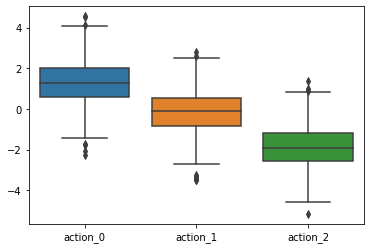

In [45]:
rd = RewardDistribution(k=3)
rd.plot()

Of course in reality you would not know this distribution. If you knew it your probabaly would have been a millionaire by now. Even though we wouldnt know this universe encoded distribution we can use the stategic approach of epsilon greedy to modle this distribution.   

In the literature we model these as <b>q_a*</b> values. $q_0$* means q star value for action 0

## Hypothesis

On average 

near greedy > greedy > random


## Experiment setup

The goal of this experiment is to compare multi arm bandit problem with greedy and epsilon $\epsilon$ greedy approach. In this experiment we will setup $k=10$ arm bandit for the slot machine and compare four epsilon approaches (0.0, 0.01, 0.1, 0.5).

In [7]:
class EpsBandit:
    def __init__(self, rd, k, eps, iterations):
        self.k = k
        self.eps = eps
        self.total_avg_reward = 0.0
        self.qa = np.zeros(self.k)
        self.ac = np.zeros(self.k)
        self.iterations = iterations
        self.rd = rd

    def sample_an_action(self):

        def greedy_action():
            # pick action corresponding to high qa
            return np.argmax(self.qa)

        def random_action():
            # pick random action from k selections
            return np.random.choice(self.k)

        if self.eps == 0:
            # always greedy choice
            return greedy_action()
        else:
            p = np.random.rand()
            # high epsilon means more weight to random actions
            if p < self.eps:
                return random_action()
            else:
                return greedy_action()

    def execute_an_action(self, action):
        sampled_rewards = self.rd.get_reward(action=action)
        self.ac[action] += 1
        return sampled_rewards

    def log(self, t, action, r_t):
        print(f'==== step {t} ====')
        print(f'Sampled a reward {r_t} for action A_{action}')
        print(f'Tr {self.total_avg_reward}')
        print(f'qa {self.qa}')
        print(f'ac {self.ac}')
        print('\n')

    def get_total_average_rewards(self):
        return self.total_avg_reward

    def run(self):
        avg_reward = [0.0]
        for t in range(1, self.iterations):
            action = self.sample_an_action()
            r_t = self.execute_an_action(action)
            self.total_avg_reward = running_average(m_n_1=self.total_avg_reward, r_i=r_t, n=t)
            self.qa[action] = running_average(m_n_1=self.qa[action], r_i=r_t, n=self.ac[action])
            avg_reward.append(float(self.total_avg_reward))
            #self.log(t, action, r_t)
        return avg_reward

epsilon 0.0 means we always take greedy actions, actions which have maximum rewards in the past. epsilon 0.5 means, 50% of the time we can actions which have maximum rewards in the past and 50% time we will be taking random actions.

Ok, now lets run this experiment.

In [51]:
def run_experiment():
    k = 10
    rd = RewardDistribution(k=k)
    
    data = {}
    
    eps_0 = EpsBandit(rd=rd, k=k, eps=0.0, iterations=1000)
    data['eps_0'] = eps_0.run()

    eps_0_0_1 = EpsBandit(rd=rd, k=k, eps=0.01, iterations=1000)
    data['eps_0_0_1'] = eps_0_0_1.run()

    eps_0_1 = EpsBandit(rd=rd, k=k, eps=0.1, iterations=1000)
    data['eps_0_1'] = eps_0_1.run()
    
    eps_0_5 = EpsBandit(rd=rd, k=k, eps=0.5, iterations=1000)
    data['eps_0_5'] = eps_0_5.run()
    
    return data


In [52]:
df = pd.DataFrame(run_experiment())
print(df.head())

      eps_0  eps_0_0_1   eps_0_1   eps_0_5
0  0.000000   0.000000  0.000000  0.000000
1  0.996909  -0.461535  0.183640 -0.188629
2  0.659377  -0.201623  1.218136 -0.104917
3  0.115318  -0.479900  0.915831  0.158654
4  0.422496  -0.345644  1.115315  0.193635


We just ran this experiment for a time step of 1000 and we the collected the running average rewards for different epsilon. As we repeat these experiments our q values will converge to q star values. 

## Running episodes

If you notice we sampled reward distribution one time <b>RewardDistribution</b> and we reused it for different epsilon experiment. We need to repeat this experiment many times with different reward distribution for our values to converge to optimal values.  

   time_step    epsilon  average_reward
0          0      eps_0        0.000000
1          0  eps_0_0_1        0.000000
2          0    eps_0_1        0.000000
3          1      eps_0        0.014747
4          1  eps_0_0_1        0.044843


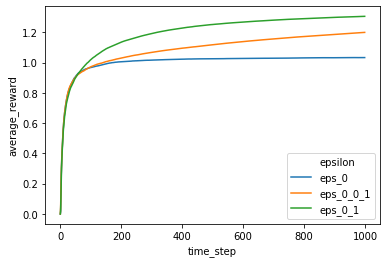

In [56]:
def run_episodes():
    episodes = 1000
    result = dict()
    result['eps_0'] = np.zeros(1000)
    result['eps_0_0_1'] = np.zeros(1000)
    result['eps_0_1'] = np.zeros(1000)
    result['eps_0_5'] = np.zeros(1000)
    for episode in range(1, episodes):
        df = pd.DataFrame(run_experiment())
        result['eps_0'] = running_average(m_n_1=result['eps_0'], r_i=np.asarray(df['eps_0']), n=episode)
        result['eps_0_0_1'] = running_average(m_n_1=result['eps_0_0_1'], r_i=np.asarray(df['eps_0_0_1']), n=episode)
        result['eps_0_1'] = running_average(m_n_1=result['eps_0_1'], r_i=np.asarray(df['eps_0_1']), n=episode)
        result['eps_0_5'] = running_average(m_n_1=result['eps_0_5'], r_i=np.asarray(df['eps_0_5']), n=episode)
        _df = pd.DataFrame(result)
    return _df

def prepare_data_for_plotting(_df):
    data_frame = dict()
    entries = []
    for time_step in range(0, 1000):
        entries.append({'time_step': time_step, 'epsilon': 'eps_0', 'average_reward': _df['eps_0'][time_step]})
        entries.append({'time_step': time_step, 'epsilon': 'eps_0_0_1', 'average_reward': _df['eps_0_0_1'][time_step]})
        entries.append({'time_step': time_step, 'epsilon': 'eps_0_1', 'average_reward': _df['eps_0_1'][time_step]})
        entries.append({'time_step': time_step, 'epsilon': 'eps_0_5', 'average_reward': _df['eps_0_5'][time_step]})
    dframe = pd.DataFrame(entries)
    return dframe
    
_df = run_episodes()
dframe = prepare_data_for_plotting(_df)
print(dframe.head())

sns.lineplot(data=dframe, x='time_step', y='average_reward', hue='epsilon')

## Conclusion

We can conclude that the hypothesis can be experimentally verified that near greedy approch converged to optimal values and maximizes the expected reward